In [1]:
# import required packages 
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler # this is for normalising our data
from sklearn.model_selection import train_test_split
import sklearn.cluster
import sklearn.mixture
import tensorflow.keras as keras
import tensorflow as tf
import time
from sklearn.metrics import accuracy_score, confusion_matrix
tf.__version__

'1.10.0'

In [2]:
#Load training and test images, and also labels
trnImages = np.load('trnImage.npy')
testImages = np.load('tstImage.npy')
testLabel = np.load('tstLabel.npy')
trnLabel = np.load('trnLabel.npy')
# Zero indexing the training and test labels(i.e. going form 0 to 9)
testLabel = testLabel-1
trnLabel = trnLabel-1
classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship','truck']

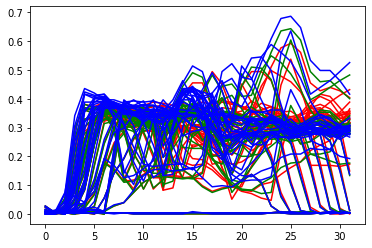

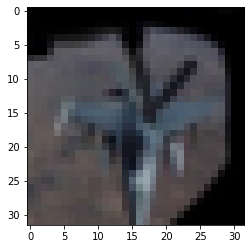

In [5]:
# Visualizing the an image and the rbg channel to get a sense of the problem
trnidx = 10
plt.figure()
plt.plot(trnImages[:,:,:,trnidx][:,:, 0], c='r', label='Red')
plt.plot(trnImages[:,:,:,trnidx][:,:, 1],  c='g', label='Green')
plt.plot(trnImages[:,:,:,trnidx][:,:, 2], c='b', label='Blue')
img = np.copy(trnImages[:,:,:,trnidx][:,:,:])
plt.show()

plt.imshow(trnImages[:,:,:,trnidx])

In [3]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

def computeFeaturesOnly(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features. 
    return skimage.feature.hog(image, block_norm='L2-Hys')
    

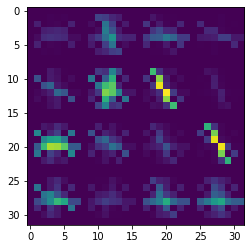

(324,)


In [0]:
# Extract the features from a single image
features, hog_image = computeFeatures(trnImages[:,:,:,0])
plt.imshow(hog_image)
plt.show(block=False)
print(features.shape)

In [11]:
#This functions computes the HOG descriptor for each image in a training or testing dataset
# and stores it each one as a row in a new matrix of size N(number of images) x 324
# it then returns it after cycling through all the arrays
def genFeatureMatrix(m):
    featureMatrix = np.zeros((m.shape[-1], 324))
    for i in range(m.shape[-1]):
        featureMatrix[i] = computeFeaturesOnly(m[:,:,:,i])
    return featureMatrix

In [12]:
# generate HOG descriptors for every image in the training and testing datasets
trnImageFeatures = genFeatureMatrix(trnImages)
testImageFeatures = genFeatureMatrix(testImages)

(10000,)


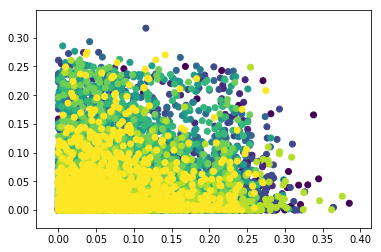

In [0]:
# Plotting two columns representing the HOG feature descriptors for all the images
# This was done in an attempt to discern the pattern with the training data
print(trnLabel[:, 0].shape)
plt.scatter(trnImageFeatures[:, 150], trnImageFeatures[:,1], c=trnLabel[:, 0])

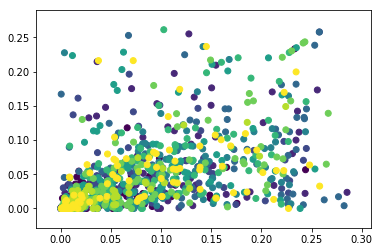

In [0]:
# Plotting two columns representing the HOG feature descriptors for all the images
# This was done in an attempt to discern the pattern with the testing data
plt.scatter(testImageFeatures[:, 0], testImageFeatures[:,1], c=testLabel[:, 0])

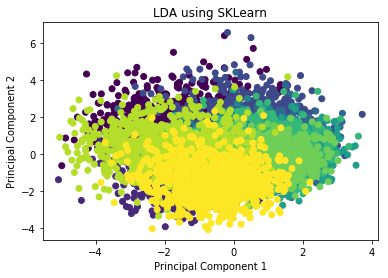

In [6]:
# Linear discriminant analysis was applied to the training and test feature matrices
# using the default number of components(n_classes - 1) 9 in this case
# then the projections on to the principal component are visaulized
lda = LinearDiscriminantAnalysis()
lda.fit(trnImageFeatures, trnLabel[:, 0])
trnImageFeaturesProjectedLDAAllComps = lda.transform(trnImageFeatures)
testImageFeaturesProjectedLDAAllComps = lda.transform(testImageFeatures)
plt.scatter(trnImageFeaturesProjectedLDAAllComps[:, 0], 
            trnImageFeaturesProjectedLDAAllComps[:, 1], 
            c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("LDA using SKLearn")
plt.show()

[38.37982713 18.71299004 13.60273773  8.20777812  5.64234729  4.90628214
  4.14471225  3.38134962  3.02197567]
(6,)


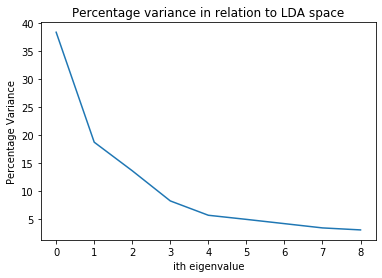

In [10]:
# Using the explained variance ratio to reduce the components from 9 to the 
# number of components that represent 90% of the variance of the data
plt.figure()
plt.plot(lda.explained_variance_ratio_*100)
var_ratio = lda.explained_variance_ratio_
print(lda.explained_variance_ratio_*100)
print(var_ratio[np.cumsum(var_ratio*100)<90].shape)
plt.title("Percentage variance in relation to LDA space")
plt.xlabel("ith eigenvalue")
plt.ylabel("Percentage Variance")
plt.show()

Text(0.5, 1.0, 'LDA using SKLearn')

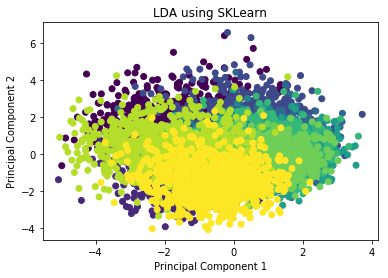

In [7]:
# It was determined that 6 components represent 90% of the data, and thus 
# a LDA object with 6 components was used to reduce the dimensionality of the
# training and test dataset. The projections are visualized. 
lda_reduced_comps = LinearDiscriminantAnalysis(n_components=6)
lda_reduced_comps.fit(trnImageFeatures, trnLabel[:, 0])
trnImageFeaturesProjected = lda_reduced_comps.transform(trnImageFeatures)
testImageFeaturesProjected = lda_reduced_comps.transform(testImageFeatures)
plt.scatter(trnImageFeaturesProjected[:, 0], 
            trnImageFeaturesProjected[:, 1], 
            c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("LDA using SKLearn")

In [0]:
# calAccTimeSVMModels calculates the training times for different SVM models
# containing different basis functions and hyper parameters such as degree and 
# gamma
def calAccTimeSVMModels(trnFeatures, testFeatures, trnLabel, tstLabel, min_c, max_c, step):
    # normalizes testing and testing data due to the poor performance of SVM models
    # on data with different scales 
    normaliser = StandardScaler().fit(trnFeatures)
    trainData = normaliser.transform(trnFeatures)
    testData = normaliser.transform(testFeatures)
    # set hyper-parameter ranges for the degree(polynomial basis function)
    # and gamma(radial basis function)
    degreeValues = np.arange(min_c,max_c+1, step)
    gamma = [0.0001*10**x for x in range(6)]
    
    # the list for storing poly SVM model results
    acc = []
    # the list for storing rbf SVM model results
    acc_rbf = []

    # this finds the training times and accuracy  for different RBF SVM models
    # by looping over the gamma hyper-parameter range and trains each model, 
    # then the accuracy(ratio of (total of each true positive for each class)/
    # (Total number of data instances)) and training time is computed for each model
    # which is then placed into the list of rbf SVM model results
    for index, gamma_val in enumerate(gamma):
        start = time.time()
        model = SVC(kernel='rbf', gamma=gamma_val)
        model.fit(trainData, trnLabel[:, 0])
        predicted_labels = model.predict(testData)
        end = time.time()
        timeTaken = end - start
        acc_rbf.append([gamma_val, accuracy_score(tstLabel[:, 0], predicted_labels), timeTaken])

    # this finds the training times and accuracy for different polynomial SVM models
    # by looping over the degree hyper parameter range and trains each model, 
    # then the accuracy(ratio of (total of each true positive for each class)/
    # (Total number of data instances)) and training time is computed
    # which is then placed into the list of poly SVM model results
    for index,degree in enumerate(degreeValues):
        start = time.time()
        model = SVC(kernel='poly', degree=degree)
        model.fit(trainData, trnLabel[:, 0])
        predicted_labels = model.predict(testData)
        end = time.time()
        timeTaken = end - start
        acc.append([degree,accuracy_score(tstLabel[:, 0], predicted_labels), timeTaken])

    return {'poly': acc, 'rbf': acc_rbf}

# calAccTimeSVMModelsReg calculates the training times for different SVM models
# containing different basis functions and hyper parameters such as degree and 
# gamma
# Regularization was added to try to fight overfitting/underfitting by trying different values for C
def calAccTimeSVMModelsReg(degrees, gammas, trnFeatures, testFeatures, trnLabel, tstLabel):
    # normalizes testing and testing data due to the poor performance of SVM models
    # on data with different scales
    normaliser = StandardScaler().fit(trnFeatures)
    trainData = normaliser.transform(trnFeatures)
    testData = normaliser.transform(testFeatures)
    # the dictionary for storing poly SVM model results
    acc = {}
    # the dictionary for storing rbf SVM model results
    acc_rbf = {}
    # set hyper-parameter ranges for the penalty of cost function for the SVM model
    C = [0.0001*10**x for x in range(7)]

    # this finds the training times and accuracy for different poly SVM models
    # by looping over the degree hyper-parameter range and then looping over the
    # penalty of cost hyper-parameter, where the accuracy and training time is computed for each model
    # which is then placed into the dictionary of poly SVM model results
    for degree in degrees:
        acc['{0} degree'.format(degree)] = []
        for index, c_value in enumerate(C):
            start = time.time()
            model = SVC(kernel='poly', degree=degree, C=c_value)
            model.fit(trainData, trnLabel[:, 0])
            predicted_labels = model.predict(testData)
            end = time.time()
            timeTaken = end - start
            acc['{0} degree'.format(degree)].append([c_value,accuracy_score(tstLabel[:, 0], predicted_labels), timeTaken ])
    
    # this finds the training times and accuracy for different rbf SVM models
    # by looping over the gamma hyper-parameter range and then looping over the
    # penalty of cost hyper-parameter, where the accuracy and training time is computed for each model
    # which is then placed into the dictionary of prbf SVM model results
    for gamma in gammas:
        acc_rbf['{0} gamma'.format(gamma)] = []
        for index, c_value in enumerate(C):
            start = time.time()
            model = SVC(kernel='rbf', gamma=gamma, C=c_value)
            model.fit(trainData, trnLabel[:, 0])
            predicted_labels = model.predict(testData)
            end = time.time()
            timeTaken = end - start
            acc_rbf['{0} gamma'.format(gamma)].append([c_value,accuracy_score(tstLabel[:, 0], predicted_labels), timeTaken ])
    return {'poly': acc, 'rbf': acc_rbf}

In [17]:
# calculate the accuracy, and training times for rbf and poly SVM models
# over certain gamma and degree ranges to determine the best performing models
# for the original feature matrix
calAccTimeSVMModels(trnImageFeatures, testImageFeatures, trnLabel, testLabel, 2, 10, 1)

{'poly': [[2, 0.576, 54.54741096496582],
  [3, 0.559, 64.03763961791992],
  [4, 0.444, 78.75190138816833],
  [5, 0.324, 79.7240240573883],
  [6, 0.222, 82.59166884422302],
  [7, 0.165, 81.92418551445007],
  [8, 0.141, 85.88224720954895],
  [9, 0.124, 83.77635169029236],
  [10, 0.112, 85.75136923789978]],
 'rbf': [[0.0001, 0.5, 57.93161344528198],
  [0.001, 0.562, 44.03729510307312],
  [0.01, 0.576, 87.9102692604065],
  [0.1, 0.107, 88.37513732910156],
  [1.0, 0.101, 90.9650776386261],
  [10.0, 0.101, 85.59103846549988]]}

In [18]:
# calculate the accuracy, and training times for rbf and poly SVM models
# over certain gamma and degree ranges to determine the best performing models
# for the reduced feature matrix(9 components)
calAccTimeSVMModels(trnImageFeaturesProjectedLDAAllComps, testImageFeaturesProjectedLDAAllComps, trnLabel, testLabel, 2, 10, 1)

{'poly': [[2, 0.399, 2.5701425075531006],
  [3, 0.494, 2.144598960876465],
  [4, 0.38, 3.0952930450439453],
  [5, 0.452, 2.6809885501861572],
  [6, 0.349, 3.35504150390625],
  [7, 0.4, 3.0593888759613037],
  [8, 0.333, 3.8071489334106445],
  [9, 0.358, 3.475224256515503],
  [10, 0.303, 4.074576377868652]],
 'rbf': [[0.0001, 0.456, 7.120059251785278],
  [0.001, 0.486, 4.303263187408447],
  [0.01, 0.491, 3.0770070552825928],
  [0.1, 0.498, 3.1293935775756836],
  [1.0, 0.444, 8.613059043884277],
  [10.0, 0.159, 7.685787677764893]]}

In [19]:
# calculate the accuracy, and training times for rbf and poly SVM models
# over certain gamma and degree ranges to determine the best performing models
# for the reduced feature matrix(6 components)
calAccTimeSVMModels(trnImageFeaturesProjected, testImageFeaturesProjected, trnLabel, testLabel, 2, 10, 1)

{'poly': [[2, 0.375, 2.4599826335906982],
  [3, 0.459, 2.0606741905212402],
  [4, 0.345, 3.20392107963562],
  [5, 0.397, 2.6855969429016113],
  [6, 0.291, 3.9017550945281982],
  [7, 0.366, 3.130852460861206],
  [8, 0.284, 4.462122201919556],
  [9, 0.342, 3.651618003845215],
  [10, 0.275, 4.754453659057617]],
 'rbf': [[0.0001, 0.426, 6.273514270782471],
  [0.001, 0.465, 4.010029315948486],
  [0.01, 0.471, 2.895326852798462],
  [0.1, 0.465, 2.8083550930023193],
  [1.0, 0.456, 5.198569297790527],
  [10.0, 0.28, 8.097044229507446]]}

In [12]:
# The computeModelMetrics computes the confusion matrix, accuracy, and training time
# It also plots the confusion matrix
def computeModelMetrics(model, trnFeatures, testFeatures, trnLabel, testLabel, title):
    # normalizes testing and testing data due to the poor performance of SVM models
    # on data with different scales
    normaliser = StandardScaler().fit(trnFeatures)
    trainData = normaliser.transform(trnFeatures)
    testData = normaliser.transform(testFeatures)
    start = time.time()
    model.fit(trainData, trnLabel[:, 0])
    predicted_labels = model.predict(testData)
    end = time.time()
    cnfMat = confusion_matrix(testLabel[:, 0],predicted_labels)
    print("Accuracy: {:.2f}%".format(accuracy_score(testLabel[:, 0], predicted_labels)*100))
    print("Time taken: {:.0f} s".format(end - start))
    plotConfusionMatrix(cnfMat, classNames, title)
    

# The plotConfusionMatrix plots the confusion matrix
def plotConfusionMatrix(confusionMatrix, classNames, title):
    plt.figure(figsize=(8,8))
    plt.imshow(confusionMatrix, cmap=plt.cm.Greens)
    plt.xticks(np.arange(confusionMatrix.shape[1]),classNames)
    plt.yticks(np.arange(confusionMatrix.shape[0]),classNames)
    plt.title(title)
    threshold  = confusionMatrix.max()/2
    for i in range(confusionMatrix.shape[0]):
        for j in range(confusionMatrix.shape[1]):
            plt.text(j, i, format(confusionMatrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusionMatrix[i, j] > threshold else "black")
    plt.show()

In [21]:
# This calculates the accuracy and training time for poly and rbf SVM models
# over the most accurate degrees and gammas, as well as the cost of penalty
# range. The original feature matrix's best performing gamma and degree
# hyper-parameter(s) are fed into the function
calAccTimeSVMModelsReg([2], 
                       [0.01], 
                       trnImageFeatures, 
                       testImageFeatures, 
                       trnLabel, 
                       testLabel)

{'poly': {'2 degree': [[0.0001, 0.257, 81.14299583435059],
   [0.001, 0.257, 81.46009159088135],
   [0.01, 0.257, 81.38789582252502],
   [0.1, 0.444, 71.56366729736328],
   [1.0, 0.576, 55.06064581871033],
   [10.0, 0.554, 67.94178938865662],
   [100.0, 0.554, 68.29080486297607]]},
 'rbf': {'0.01 gamma': [[0.0001, 0.302, 89.4556736946106],
   [0.001, 0.302, 89.38061141967773],
   [0.01, 0.302, 88.82169842720032],
   [0.1, 0.301, 88.66200089454651],
   [1.0, 0.576, 87.21818041801453],
   [10.0, 0.586, 87.72686052322388],
   [100.0, 0.586, 87.79627823829651]]}}

Accuracy: 58.60%
Time taken: 87 s


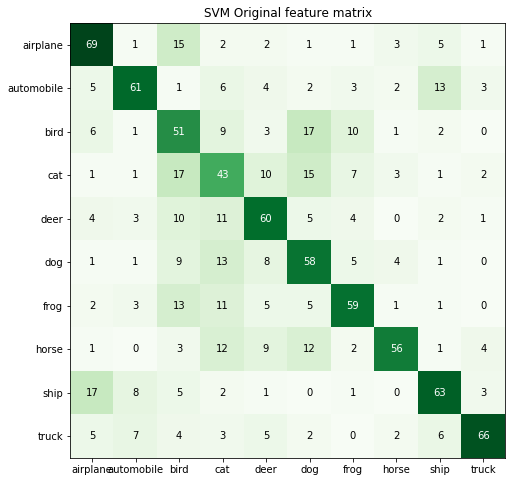

In [27]:
# This computes the confusion matrix, accuracy, and time taken
#  for the best performing regularized model 
# for the original feature matrix
computeModelMetrics(SVC(kernel='rbf', gamma=0.01, C=10), 
                    trnImageFeatures, testImageFeatures, 
                    trnLabel, testLabel,'SVM Original feature matrix')

In [28]:
# This calculates the accuracy and training time for poly and rbf SVM models
# over the most accurate degrees and gammas, as well as the cost of penalty
# range. The reduced feature matrix(9 components) best performing gamma 
# and degree hyper-parameter(s) are fed into the function
calAccTimeSVMModelsReg([], [0.1],trnImageFeaturesProjectedLDAAllComps, 
                       testImageFeaturesProjectedLDAAllComps, trnLabel, 
                       testLabel)

{'poly': {},
 'rbf': {'0.1 gamma': [[0.0001, 0.484, 7.121250152587891],
   [0.001, 0.484, 7.127076625823975],
   [0.01, 0.486, 5.907498598098755],
   [0.1, 0.498, 3.501828193664551],
   [1.0, 0.498, 3.0588090419769287],
   [10.0, 0.493, 3.9662790298461914],
   [100.0, 0.463, 9.74015188217163]]}}

Accuracy: 49.80%
Time taken: 3 s


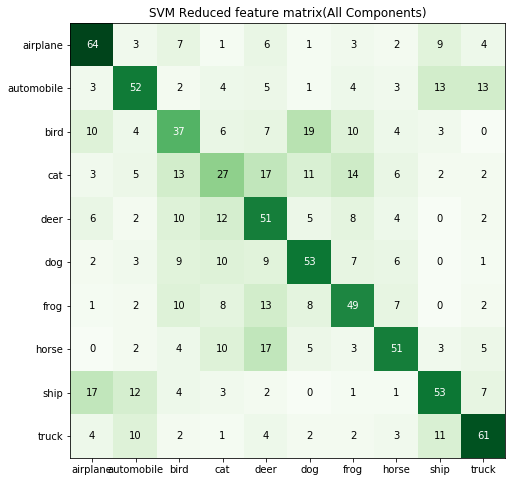

In [29]:
# This computes the confusion matrix, accuracy, and time taken
# for the best performing regularized model 
# for the reduced feature matrix(9 components)
computeModelMetrics(SVC(kernel='rbf', gamma=0.1, C=1),
                    trnImageFeaturesProjectedLDAAllComps, 
                    testImageFeaturesProjectedLDAAllComps, 
                    trnLabel, testLabel,
                    'SVM Reduced feature matrix(All Components)')

In [23]:
# This calculates the accuracy and training time for poly and rbf SVM models
# over the most accurate degrees and gammas, as well as the cost of penalty
# range. The reduced feature matrix(6 components) best performing gamma 
# and degree hyper-parameter(s) are fed into the function
calAccTimeSVMModelsReg([],[0.01],
                       trnImageFeaturesProjected, 
                       testImageFeaturesProjected, 
                       trnLabel, testLabel)

{'poly': {},
 'rbf': {'0.01 gamma': [[0.0001, 0.431, 6.369664430618286],
   [0.001, 0.431, 6.368564605712891],
   [0.01, 0.442, 6.348833084106445],
   [0.1, 0.469, 4.05653977394104],
   [1.0, 0.471, 2.829418659210205],
   [10.0, 0.478, 2.737452507019043],
   [100.0, 0.471, 3.469137191772461]]}}

Accuracy: 47.80%
Time taken: 3 s


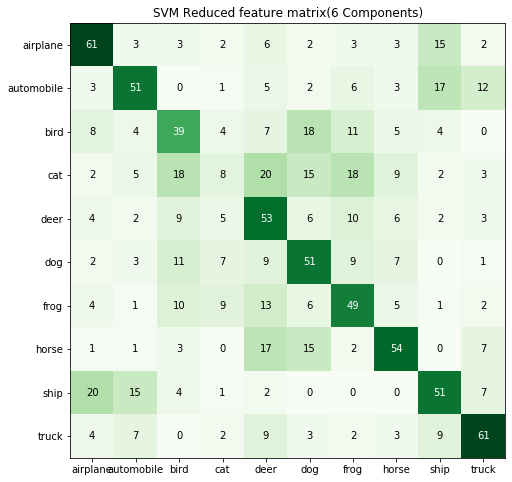

In [30]:
# This computes the confusion matrix, accuracy, and time taken
# for the best performing regularized model 
# for the reduced feature matrix(6 components)
computeModelMetrics(SVC(kernel='rbf', gamma=0.01, C=10), 
                    trnImageFeaturesProjected, 
                    testImageFeaturesProjected, 
                    trnLabel, 
                    testLabel,
                    'SVM Reduced feature matrix(6 Components)')

In [8]:
# network_train creates ANN MLP models by stacking an input layer and a soft max output layer
# between hidden layer(s) specified by the user, and returns it.
# It also plots the loss and accuracy curves for the model created
def network_train(layers, 
						units, 
						trainData, 
						train_labels, 
						testData, 
						test_labels, 
						activation='sigmoid', 
						number_of_classes=10, 
						epochs=1000):
    # normalize testing and testing data due to the poor performance of ANN models
    # on data with different scales 
    start = time.time()
    normaliser = StandardScaler().fit(trainData)
    train_data = normaliser.transform(trainData)
    test_data = normaliser.transform(testData)
    # split the training data into training and validation data 
    # on data with different scales 
    X_train, X_validation, y_train, y_validation = train_test_split(train_data, 
                                                                    train_labels, 
                                                                    test_size=0.10,
                                                                    stratify=train_labels,
                                                                    random_state=10)
    # Build our network architecture by stacking layers in a Keras Sequential object.
    model = keras.Sequential()

    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1],)))


    # Create hidden layers
    for i in range(layers):
        model.add(keras.layers.Dense(units, activation=activation))
        

    # Create output layer to get predicted class labels.
    model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

    # Generate a callable keras Model object which contains our architecture.
    # This allows us to train and predict our neural network on the datasets.
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])

    # Fit our model to the data
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, verbose=0)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = model.predict(test_data)
    end = time.time()

    # print out the training time in minutes and seconds
    total_time = int(end-start)
    print("{0} minutes {1} seconds".format(total_time//60, total_time%60))
    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
    # Calculate the percentage accuracy rate on test set
    plot_acc_loss(history)
    acc = np.mean(test_labels == predicted_labels)
    print(acc*100)
    return model

# network_train creates ANN MLP models by stacking an input layer and a soft max output layer
# between hidden layer(s) specified by the user, and returns it.
# It also plots the loss and accuracy curves for the model created.
# Hyper-parameter tuning and regulariaztion is available here, inorder to get the most out of the model
def network_train_reg(layers, 
						units, 
						trainData, 
						train_labels, 
						testData, 
						test_labels, 
						activation='sigmoid', 
						number_of_classes=10, 
						epochs=1000, 
						l2_reg=0.0001, 
						learning_rate=0.001,
            momentum=0.9):
    # normalize testing and testing data due to the poor performance of ANN models
    # on data with different scales
    start = time.time()
    model = keras.Sequential()
    normaliser = StandardScaler().fit(trainData)
    train_data = normaliser.transform(trainData)
    test_data = normaliser.transform(testData)
    # Build our network architecture by stacking layers in a Keras Sequential object.
    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1],)))

    # Create hidden layers
    for i in range(layers):
        model.add(keras.layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l2_reg)))
    # Create output layer to get predicted class labels.
    model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

    # Generate a callable keras Model object which contains our architecture.
    # This allows us to train and predict our neural network on the datasets.
    model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=True), 
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    # Fit our model to the data
    history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=epochs, verbose=0)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = model.predict(test_data)

    # print out the training time in minutes and seconds
    end = time.time()
    total_time = int(end-start)
    print("{0} minutes {1} seconds".format(total_time//60, total_time%60))

    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
    # Calculate the percentage accuracy rate on test set
    plot_acc_loss(history)
    acc = np.mean(test_labels == predicted_labels)
    print(acc*100)
    return model




def plot_acc_loss(history):
    plt.figure()
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    


14 minutes 57 seconds


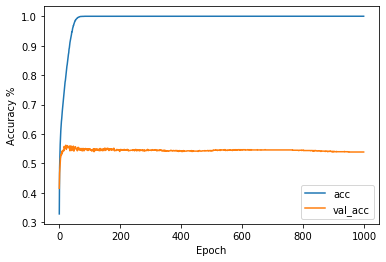

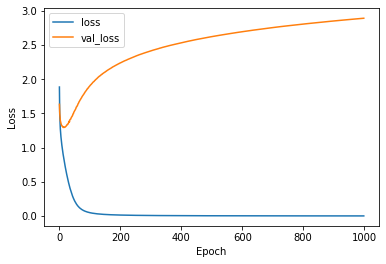

54.6


In [0]:
ann_1layer = network_train(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu')

15 minutes 4 seconds


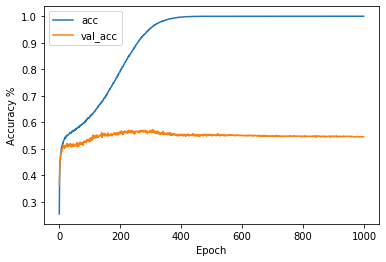

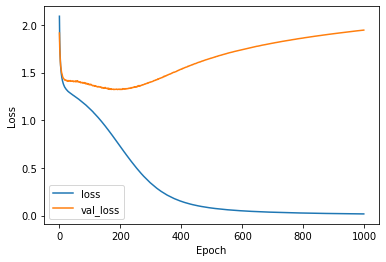

51.9


In [0]:
ann_1layer_sigmoid = network_train(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='sigmoid')

15 minutes 10 seconds


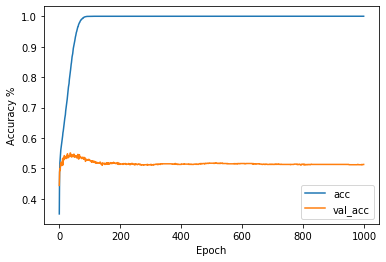

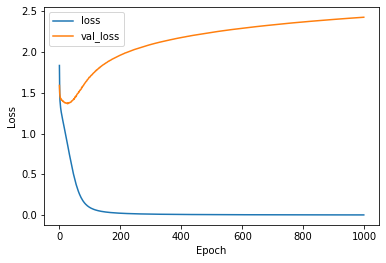

51.5


In [0]:
ann_1layer_tanh = network_train(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='tanh')

learning rate: 1e-05
3 minutes 33 seconds


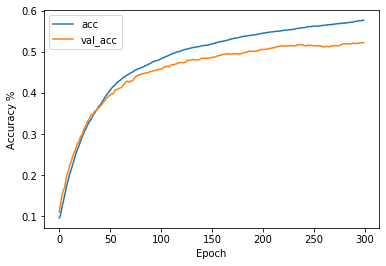

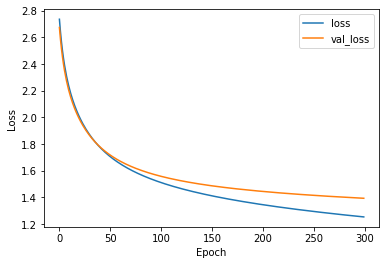

52.2
learning rate: 0.0001
3 minutes 33 seconds


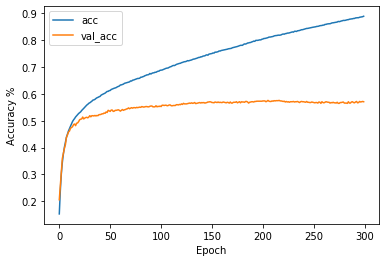

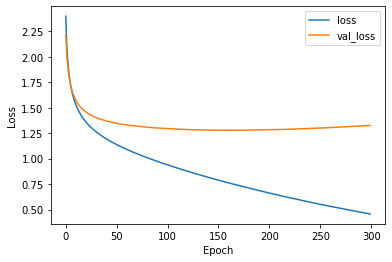

57.099999999999994
learning rate: 0.001
3 minutes 28 seconds


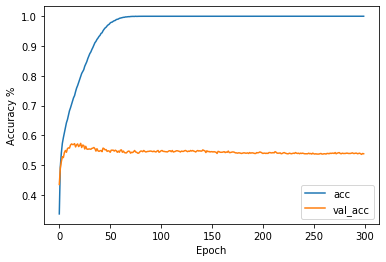

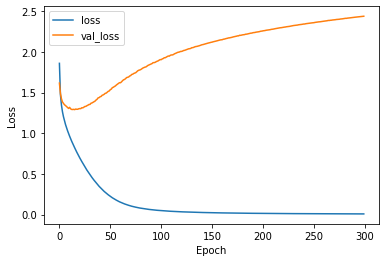

53.800000000000004
learning rate: 0.01
3 minutes 25 seconds


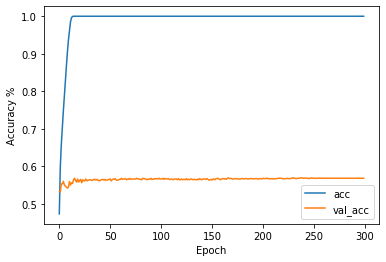

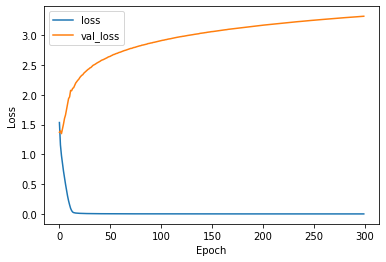

56.8
learning rate: 0.1
3 minutes 27 seconds


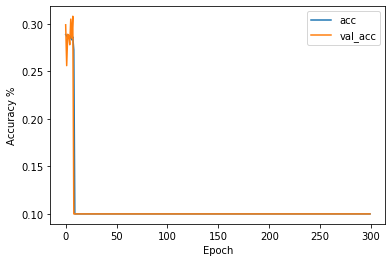

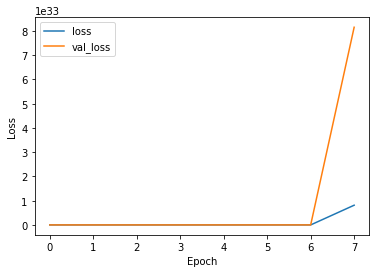

10.0
learning rate: 1.0
3 minutes 26 seconds


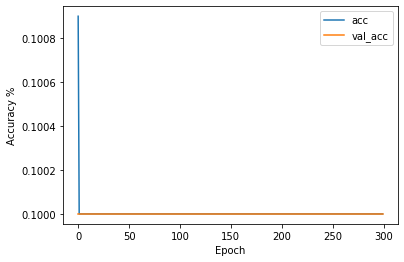

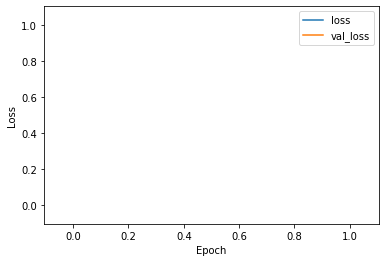

10.0
learning rate: 10.0
3 minutes 24 seconds


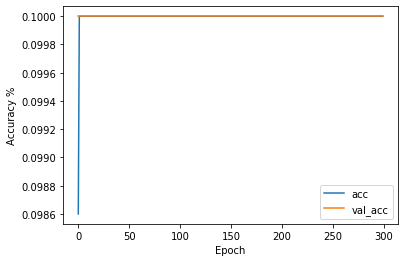

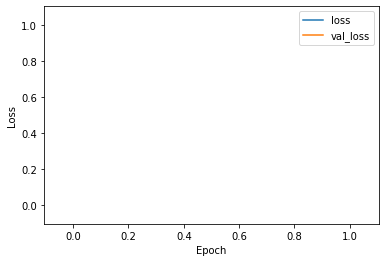

10.0


In [0]:
# First find a good learning rate by checking rates between 10^-5 and 10
# The validation and training loss curves are evaluated to determine the best learning rate
for i in range(7):
  print("learning rate: {0}".format(10**-5 *10**i))
  network_train_reg(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5 *10**i,
                    l2_reg=0,
                    epochs=300)


36 minutes 25 seconds


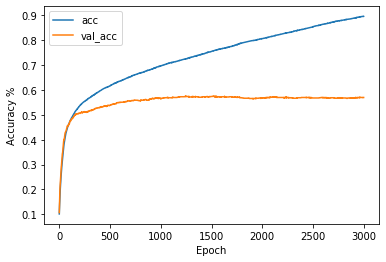

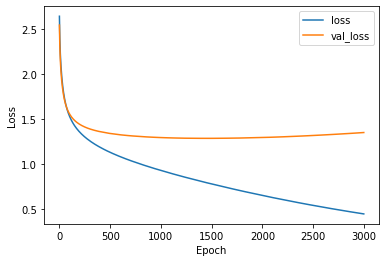

56.99999999999999


In [33]:
# The learning rate of 10**-5 was chosen due to having the lowest gap between
# the validation loss and training loss curves, also the shape of the curves
# were indicative of a good learning rate
ann = network_train_reg(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0,
                    epochs=3000)

36 minutes 57 seconds


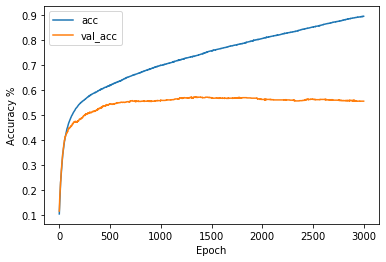

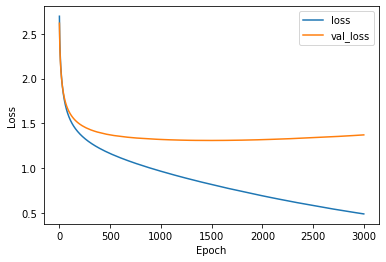

55.50000000000001


In [34]:
# There are signs of overfitting since there is a signgicant gap between the validation accuracy
# and testing accuracy
# adding regularization should help close the gap
ann = network_train_reg(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0.0001,
                    epochs=3000)

49 minutes 33 seconds


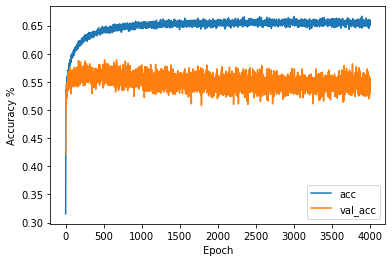

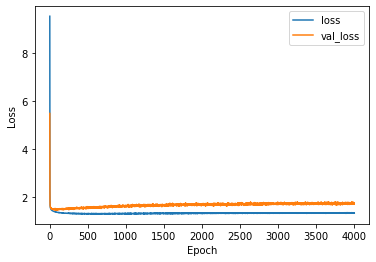

55.60000000000001


In [49]:
# Regularization did not help, so the number of units will be reduced to help reduce the 
# overfitting and regularization was increased
# the learning rate seems too slow so it was increased
ann = network_train_reg(1, 
                    int(trnImageFeatures.shape[1]/4), 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-3,
                    l2_reg=0.1,
                    epochs=4000)

39 minutes 41 seconds


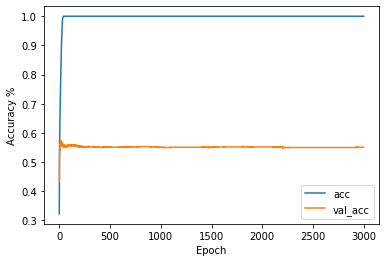

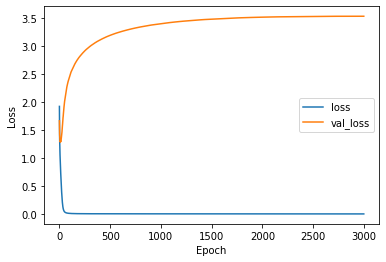

55.1


In [48]:
#The hyper-parameter tunings have not work as expected so the most accurate model 
# so far was rechosen and a little bit of regularization was added and along with more layers
# and a higher learning rate
ann = network_train_reg(1*2, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-3,
                    l2_reg=0.00001,
                    epochs=3000)

50 minutes 29 seconds


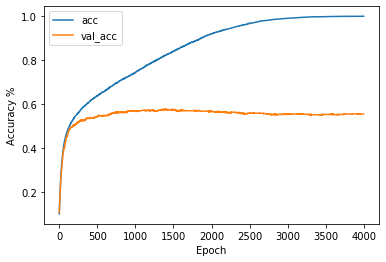

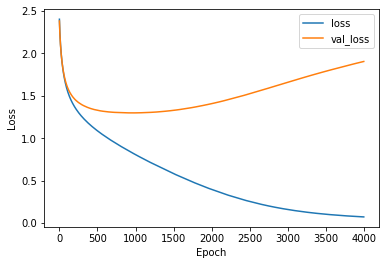

55.50000000000001


In [13]:
#The hyper-parameter tunings have not work as expected so the most accurate model 
# so far was rechosen and a little bit of regularization was added and along with more layers
# and a higher learning rate
ann = network_train_reg(1*2, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0.00001,
                    epochs=4000)

15 minutes 49 seconds


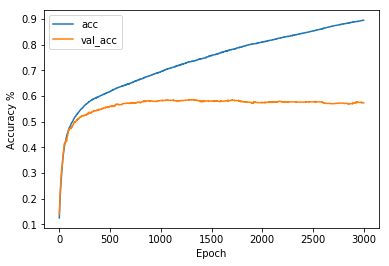

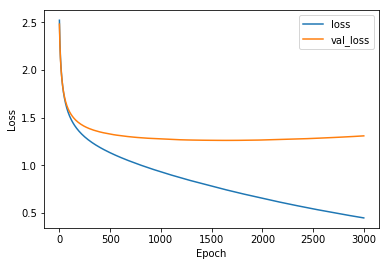

57.3


In [14]:
#  The tuning attempts didnt get any higher than the initial configuration
# so this will be used since it is the most accurate so far
ann = network_train_reg(1, 
                    trnImageFeatures.shape[1], 
                    trnImageFeatures, trnLabel[:, 0],
                    testImageFeatures, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0,
                    epochs=3000)

7 minutes 23 seconds


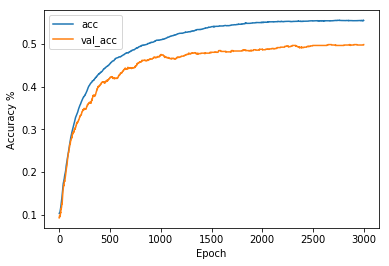

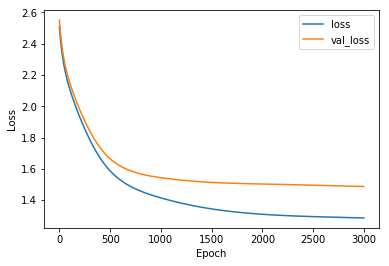

49.8


In [15]:
#  The tuning attempts didnt get any higher than the initial configuration
# so this will be used since it is the most accurate so far
ann_reduced_9 = network_train_reg(1, 
                    trnImageFeaturesProjectedLDAAllComps.shape[1], 
                    trnImageFeaturesProjectedLDAAllComps, trnLabel[:, 0],
                    testImageFeaturesProjectedLDAAllComps, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0,
                    epochs=3000)

7 minutes 25 seconds


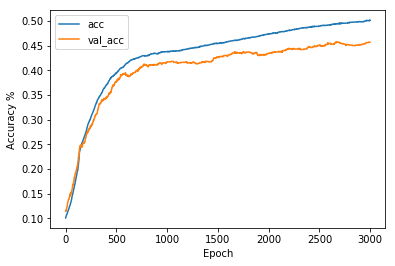

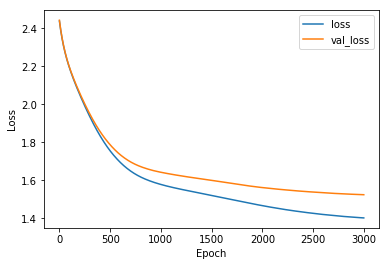

45.7


In [16]:
ann_reduced_6 = network_train_reg(1, 
                    trnImageFeaturesProjected.shape[1], 
                    trnImageFeaturesProjected, trnLabel[:, 0],
                    testImageFeaturesProjected, testLabel[:, 0],
                    activation='relu',
                    learning_rate=10**-5,
                    l2_reg=0,
                    epochs=3000)

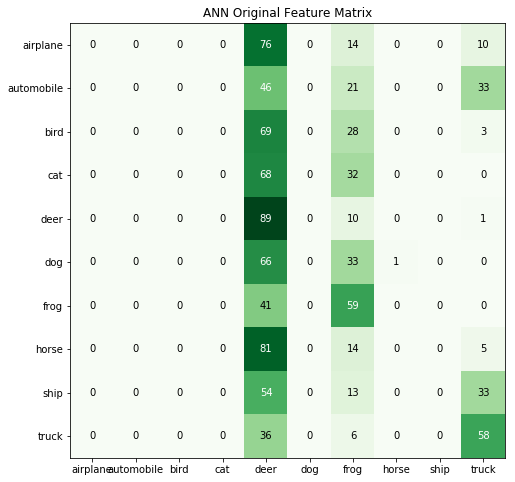

In [17]:
predicted_probabilities = ann.predict(testImageFeatures)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
confusionMatrix = tf.confusion_matrix(labels=testLabel, predictions=predicted_labels, num_classes=10)
plotConfusionMatrix(confusionMatrix.eval(), classNames, 'ANN Original Feature Matrix')

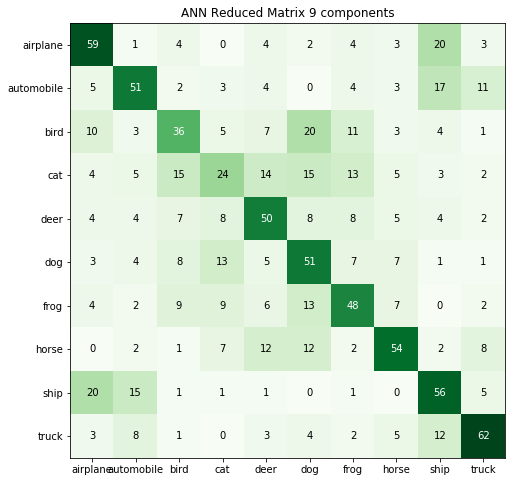

In [18]:
predicted_probabilities = ann_reduced_9.predict(testImageFeaturesProjectedLDAAllComps)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
confusionMatrix = tf.confusion_matrix(labels=testLabel, predictions=predicted_labels, num_classes=10)
plotConfusionMatrix(confusionMatrix.eval(), classNames, 'ANN Reduced Matrix 9 components')

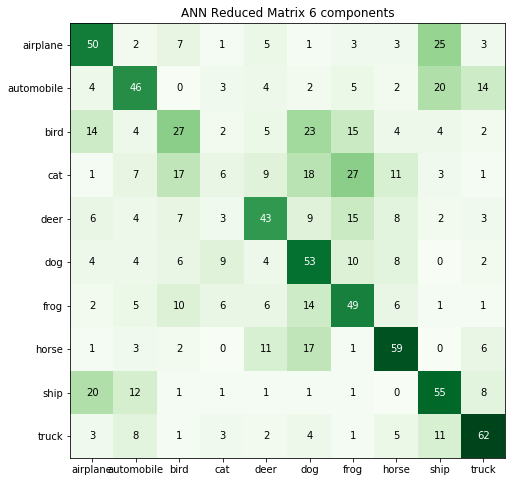

In [19]:
predicted_probabilities = ann_reduced_6.predict(testImageFeaturesProjected)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
confusionMatrix = tf.confusion_matrix(labels=testLabel, predictions=predicted_labels, num_classes=10)
plotConfusionMatrix(confusionMatrix.eval(), classNames, 'ANN Reduced Matrix 6 components')